In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
nourth = pd.read_csv(r"C:\Users\shryf\Desktop\Nasa\North_Egypt.csv")
south = pd.read_csv(r"C:\Users\shryf\Desktop\Nasa\South_Egypt.csv")
middle = pd.read_csv(r"C:\Users\shryf\Desktop\Nasa\Middle_Egypt.csv")

In [86]:
df = pd.concat([nourth, south, middle], ignore_index=True)

In [87]:
df.head()

,time,rainfall,humidity,temperature,wind_speed,region
0,2020-01-01,0.278920,44.130760,14.412500,3.056337,North
1,2020-01-02,0.347130,83.099998,13.537500,6.380021,North
2,2020-01-03,2.541833,98.666664,12.391657,8.807236,North
3,2020-01-04,3.915054,88.500000,13.850000,6.344940,North
4,2020-01-05,0.072273,73.199997,15.187494,5.542528,North


In [88]:
(df["rainfall"] > 1).sum()

151

In [89]:
df.value_counts('region')

region
Middle    1945
North     1945
South     1945
Name: count, dtype: int64

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5835 entries, 0 to 5834
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         5835 non-null   object 
 1   rainfall     5835 non-null   float64
 2   humidity     5835 non-null   float64
 3   temperature  5835 non-null   float64
 4   wind_speed   5835 non-null   float64
 5   region       5835 non-null   object 
dtypes: float64(4), object(2)
memory usage: 273.6+ KB


In [91]:
threshold = 0.0   

# binary label: 0 = no rain, 1 = rain
df['rain_label'] = (df['rainfall'] > threshold).astype(int)

In [92]:
df['rain_label'].value_counts()

rain_label
0    3826
1    2009
Name: count, dtype: int64

In [93]:
df['time'] = pd.to_datetime(df['time'])

In [94]:
df['month'] = df['time'].dt.month
df['dayofyear'] = df['time'].dt.dayofyear

In [95]:
# cyclical encoding
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
df["doy_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
df["doy_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365)

In [96]:
df.sample()

,time,rainfall,humidity,temperature,wind_speed,region,rain_label,month,dayofyear,month_sin,month_cos,doy_sin,doy_cos
3795,2025-02-25,0.0,28.589132,20.409266,5.005306,South,0,2,56,0.866025,0.5,0.821477,0.570242


In [97]:
clim = df.groupby(['region', 'dayofyear']).agg(
    clim_temp_mean = ('temperature','mean'),
    clim_rain_prob  = ('rain_label','mean')   
).reset_index()

df = df.merge(clim, on=['region','dayofyear'], how='left')

In [98]:
# one-hot encode region
df = pd.get_dummies(df, columns=['region'], prefix='region')

In [99]:
df['humid_wind'] = df['humidity'] * df['wind_speed']
df['temp_humid'] = df['temperature'] * df['humidity']

In [100]:
df['temp_lag1'] = df['temperature'].shift(1)
df['rain_lag1'] = df['rain_label'].shift(1)

In [101]:
# Rolling features
df['temp_rolling7'] = df['temperature'].rolling(7).mean()
df['rain_rolling7'] = df['rainfall'].rolling(7).sum()

In [102]:
df.sample()

,time,rainfall,humidity,temperature,wind_speed,rain_label,month,dayofyear,month_sin,month_cos,...,clim_rain_prob,region_Middle,region_North,region_South,humid_wind,temp_humid,temp_lag1,rain_lag1,temp_rolling7,rain_rolling7
3369,2023-12-23,0.0,37.85733,18.625635,4.003859,0,12,357,-2.449294e-16,1.0,...,0.2,False,False,True,151.575394,705.11682,19.054163,0.0,21.669764,0.0


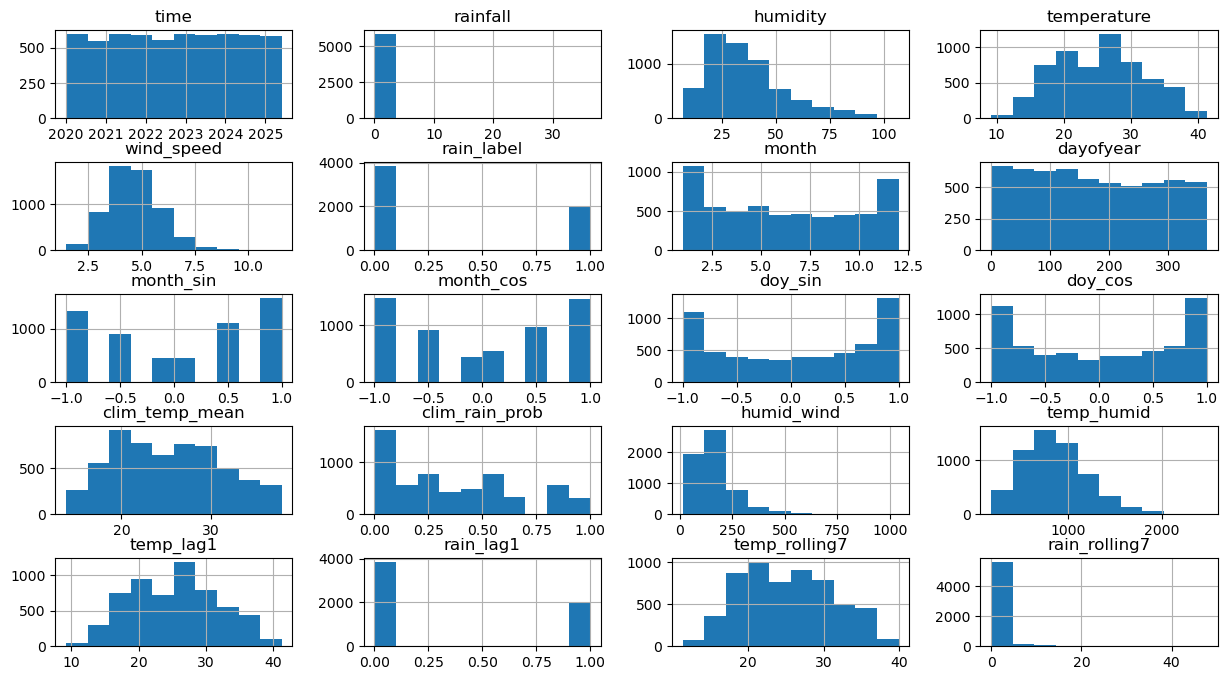

In [103]:
df.hist(figsize=(15,8))
plt.subplots_adjust(hspace=0.5,wspace=0.3)
plt.show()

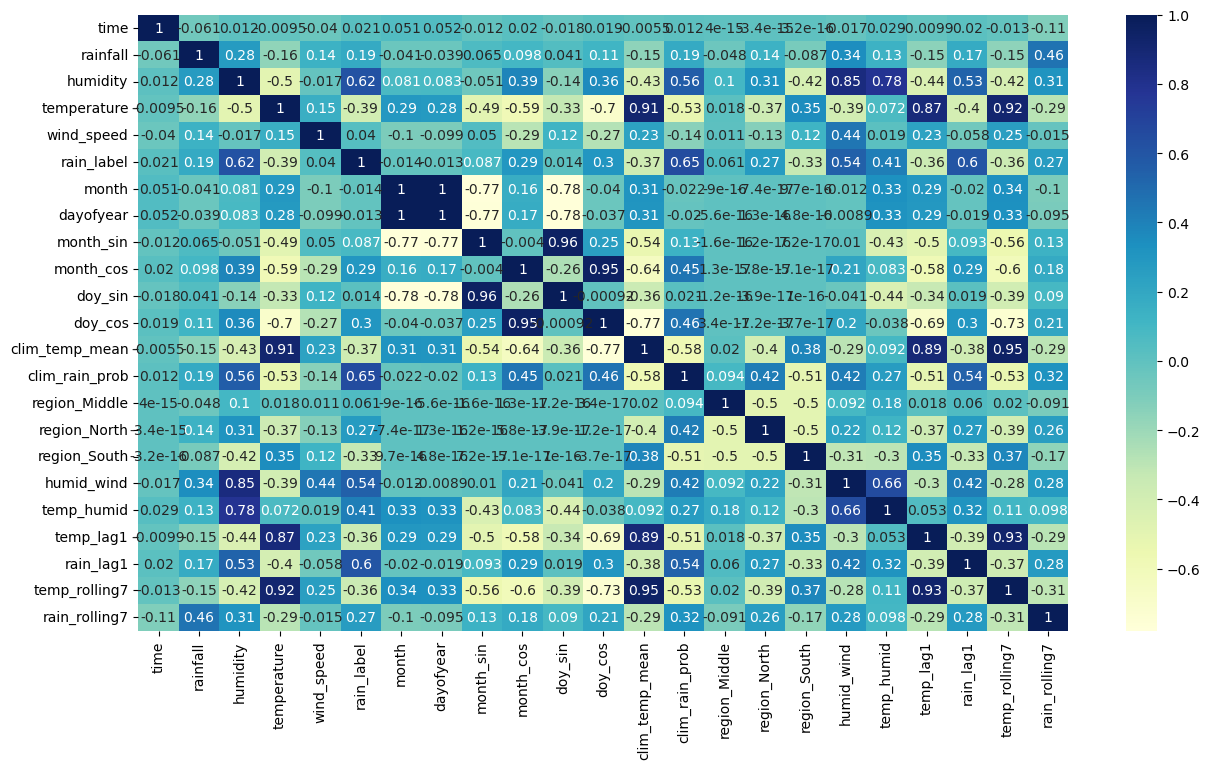

In [104]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(),annot=True,cmap='YlGnBu')
plt.show()

In [105]:
# features  & targets 

feature_cols_temp = df.drop(columns=['time', 'rainfall', 'temperature', 'month', 'dayofyear', 'rain_label', 'clim_rain_prob']).columns
target_temp = "temperature"

feature_cols_rain = df.drop(columns=['time', 'rainfall', 'month', 'dayofyear', 'rain_label']).columns
target_rain = "rain_label" 

In [106]:
# Spliting data
df = df.sort_values('time').reset_index(drop=True)

split_df = int(len(df)*0.8)
train = df.iloc[:split_df]
test = df.iloc[split_df:]

# Temperature 
x_train_temp = train[feature_cols_temp].values
y_train_temp  = train[target_temp].values

x_test_temp = test[feature_cols_temp].values
y_test_temp  = test[target_temp].values

# Rain 
x_train_rain = train[feature_cols_rain].values
y_train_rain  = train[target_rain].values

x_test_rain = test[feature_cols_rain].values
y_test_rain  = test[target_rain].values

# Temperature Model

### ***RandomForestRegressor***

In [107]:
from sklearn.ensemble import RandomForestRegressor

In [108]:
rfr = RandomForestRegressor(n_estimators=400, max_depth=7, random_state=42)
rfr.fit(x_train_temp, y_train_temp)
rfr.score(x_train_temp, y_train_temp)

0.9433249801978294

In [109]:
rfr.score(x_test_temp, y_test_temp)

0.8999397129574713

# Rain Model

In [110]:
from sklearn.ensemble import RandomForestClassifier

In [111]:
rfc = RandomForestClassifier(n_estimators=400, max_depth=7, random_state=42)
rfc.fit(x_train_rain, y_train_rain)
rfc.score(x_train_rain, y_train_rain)

0.9190231362467867

In [112]:
rfc.score(x_test_rain, y_test_rain)

0.8928877463581834

In [113]:
import joblib
joblib.dump(rfr, "temperature_model.pkl")
joblib.dump(rfc, "rain_model.pkl")

['rain_model.pkl']

In [114]:
# Temperature features
joblib.dump(feature_cols_temp, "feature_cols_temp.pkl")

# Rain features
joblib.dump(feature_cols_rain, "feature_cols_rain.pkl")

['feature_cols_rain.pkl']